# import dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
df = read_csv('processed_data.csv')
df.head()

Unnamed: 0        date                 time       account  \
0           1  2021-02-10  2021-07-03 18:15:00  430405884063   
1           3  2021-02-10  2021-07-03 18:15:00  430405884063   
2           5  2021-02-10  2021-07-03 18:15:00  430405884063   
3           7  2021-02-10  2021-07-03 18:15:00  430405884063   
4           9  2021-02-10  2021-07-03 18:15:00  430405884063   

               interface     sourceIP          destIP  srcPort  dstPort  \
0  eni-0b6ce86ea40aaa41b  172.16.1.52  50.245.225.205       80     9622   
1  eni-0b6ce86ea40aaa41b  172.16.1.52  50.245.225.205       80    22050   
2  eni-0b6ce86ea40aaa41b  172.16.1.52  50.245.225.205       80    51466   
3  eni-0b6ce86ea40aaa41b  172.16.1.52  50.245.225.205       80    49748   
4  eni-0b6ce86ea40aaa41b  172.16.1.52  50.245.225.205       80    18681   

   protocol  packets   byte   startTime  timeTook  status  Cattemptlastsec  \
0         6        5    689  1612980900         9       1              1.0   
1         6        5    582  1612980900         9       1              2.0   
2         6       11  10996  1612980900         9       1              3.0   
3         6       13  12958  1612980900         9       1              4.0   
4         6        5    638  1612980900         9       1              5.0   

   Rlastsec  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

Remove unneeded Collumns and reformat numbers to integers

In [3]:
# Remove Unneeded Columns
df.pop("interface")
df.pop("account")
df.pop("Unnamed: 0")
df.pop('date')
df.pop('Rlastsec')
df.pop('time')
df.pop('protocol')
df.pop('srcPort')
df.pop('dstPort')
df.pop('Cattemptlastsec')



#only IPs based on sec, number of same reponse(same source and dest ip), accept rate, startTime, average timeTook

df.pop('byte')
df.pop('packets')

# Reformat numbers
df['sourceIP'] = df['sourceIP'].str.replace(r'\D', '')
df['destIP'] = df['destIP'].str.replace(r'\D', '')
df['sourceIP'] = pd.to_numeric(df['sourceIP'])
df['destIP'] = pd.to_numeric(df['destIP'])
df['startTime'] = pd.to_numeric(df['startTime'])
df['timeTook'] = pd.to_numeric(df['timeTook'])
df['status'] = pd.to_numeric(df['status'])

df.head()

<ipython-input-3-9e48dbf01f4b>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sourceIP'] = df['sourceIP'].str.replace(r'\D', '')
<ipython-input-3-9e48dbf01f4b>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['destIP'] = df['destIP'].str.replace(r'\D', '')


sourceIP       destIP   startTime  timeTook  status
0  17216152  50245225205  1612980900         9       1
1  17216152  50245225205  1612980900         9       1
2  17216152  50245225205  1612980900         9       1
3  17216152  50245225205  1612980900         9       1
4  17216152  50245225205  1612980900         9       1

In [13]:
df = df.sort_values(['startTime','sourceIP', 'destIP',],ascending=[True, True, True])
df = df.reset_index(drop=True)
df.head()

sourceIP     destIP   startTime  timeTook  status
0  17216152  172161196  1612980720         8       1
1  17216152  172161196  1612980720         8       1
2  17216152  172161196  1612980720         8       1
3  17216152  172161196  1612980720         8       1
4  17216152  172161196  1612980720         8       1

In [20]:
#preprocess the data
#O(n)
processedDf = pd.DataFrame({
    "sourceIP":[],
    "destIP":[],
    "numOfRequest":[],
    "time":[],
    "acceptanceRate":[],
    "averageTimeTook":[],
})
for index, line in df.iterrows():
    if index == 0:
        m = 100
        if line['status'] == 0:
            m = 0
        processedDf.loc[0] = [line['sourceIP'],line['destIP'],1,line['startTime'],m,line['timeTook']]
    else:
        n = len(processedDf)-1
        if processedDf.loc[n,'sourceIP']==line['sourceIP'] and processedDf.loc[n,'destIP']==line['destIP'] and processedDf.loc[n,'time']==line['startTime']:
            x = processedDf.loc[n,'numOfRequest']
            processedDf.loc[n,'numOfRequest'] = x + 1
            if line['status'] == 1:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01)+1)/(x+1)) * 100
            else:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01))/(x+1)) * 100
            processedDf.loc[n,'averageTimeTook'] = ((processedDf.loc[n,'averageTimeTook'] * x)+line['timeTook'])/(x+1)
        else:
            m = 100
            if line['status'] == 0:
                m = 0
            processedDf.loc[n+1] = [line['sourceIP'],line['destIP'],1,line['startTime'],m,line['timeTook']]
processedDf.head()

sourceIP       destIP  numOfRequest          time  acceptanceRate  \
0   17216152.0  172161196.0           5.0  1.612981e+09           100.0   
1   17216152.0  502303538.0           4.0  1.612981e+09           100.0   
2  172161196.0   17216152.0           5.0  1.612981e+09           100.0   
3  502303538.0   17216152.0           4.0  1.612981e+09           100.0   
4   10325299.0  172161196.0           5.0  1.612981e+09           100.0   

   averageTimeTook  
0              8.0  
1              8.0  
2              8.0  
3              8.0  
4             13.0

In [21]:
processedDf.to_csv('processed_data2.csv')

View data to determine correlations, groupings, outliers, and any other trends (only 5% of the data graphed)

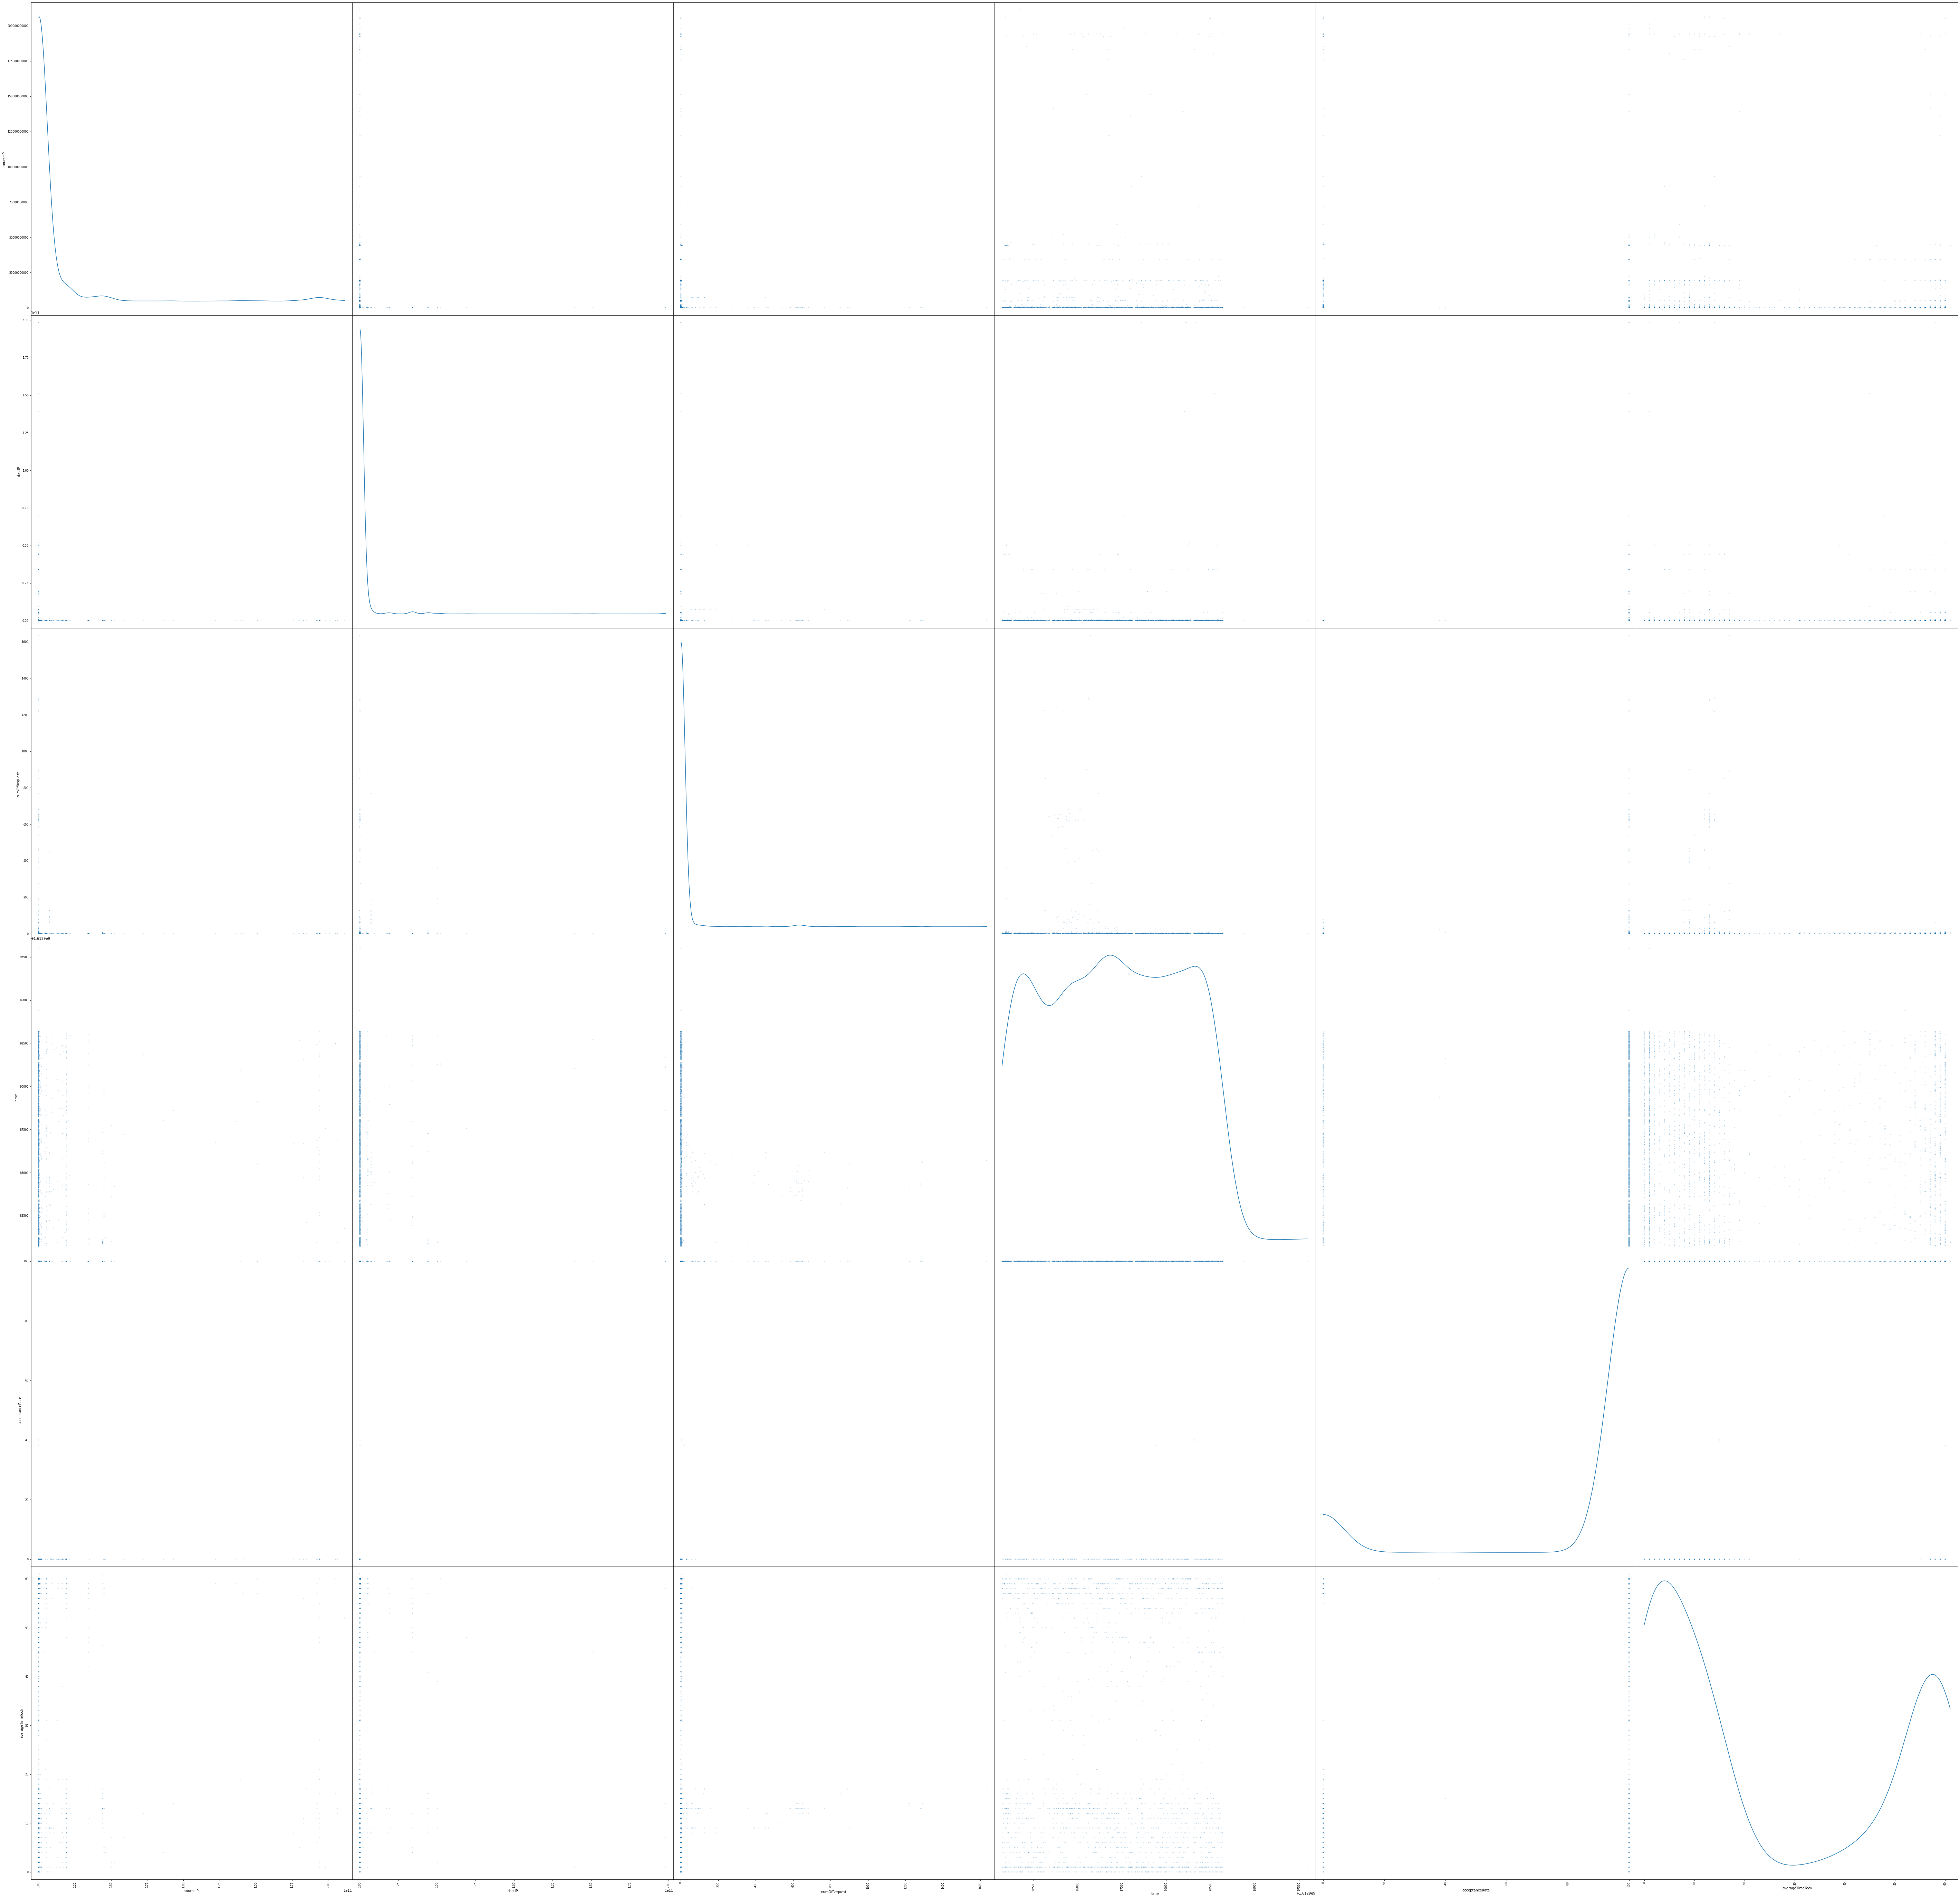

In [22]:
fig = scatter_matrix(processedDf.sample(frac=0.05), alpha=0.2,figsize=(100,100), diagonal="kde")  

PCA Analysis to determine most important characteristics to describe data. PCA Analysis seeks to maintain the "distance" between points in as few features as possible. From this analysis, all 8 selected features are independent. This could indicate that our features do not describe our data well and instead, more features should be relations between features such as frequency of a certain signal

In [23]:
df = processedDf    

In [24]:
rank = 3
n_features = len(df.index)
n_components = np.arange(0, n_features, n_features)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


X = df.sample(frac=0.5).values  # Reduce the number of points by selecting 5% of the data. Analysis should hold
pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
            label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
            label='FactorAnalysis CV: %d' % n_components_fa,
            linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
            label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

# compare with other covariance estimators
plt.axhline(shrunk_cov_score(X), color='violet',
            label='Shrunk Covariance MLE', linestyle='-.')
plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('Data Description versus Number of Components')

plt.show()

best n_components by PCA CV = 0
best n_components by FactorAnalysis CV = 0
best n_components by PCA MLE = 5


# Machine Learning

In [25]:
x_train, x_text = train_test_split(df.values)

# Outlier Detection
Local Outlier Factor - computes a score of how unusual a given data point is. Higher LOF (color in graphs means more normal)

In [26]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
outlier = clf.fit_predict(df.values)
score = clf.negative_outlier_factor_

In [27]:
len(score)

44465

In [28]:
df['score'] = score

In [44]:
highestScore = df['score'].max()
for index, line in df.iterrows():
    line['score'] = line['score']/highestScore

In [45]:
df.head(10)

sourceIP       destIP  numOfRequest          time  acceptanceRate  \
0   17216152.0  172161196.0           5.0  1.612981e+09           100.0   
1   17216152.0  502303538.0           4.0  1.612981e+09           100.0   
2  172161196.0   17216152.0           5.0  1.612981e+09           100.0   
3  502303538.0   17216152.0           4.0  1.612981e+09           100.0   
4   10325299.0  172161196.0           5.0  1.612981e+09           100.0   
5   17216152.0  172161196.0           4.0  1.612981e+09           100.0   
6   17216196.0  172161196.0           1.0  1.612981e+09           100.0   
7  172161196.0   10325299.0           5.0  1.612981e+09           100.0   
8  172161196.0   17216152.0           4.0  1.612981e+09           100.0   
9  172161196.0   17216196.0           1.0  1.612981e+09           100.0   

   averageTimeTook         score  
0              8.0  1.097716e-07  
1              8.0  1.709388e-06  
2              8.0  1.103098e-07  
3              8.0  1.708891e-06  
4             13.0  1.190974e-07  
5             13.0  1.095995e-07  
6             13.0  1.157794e-07  
7             13.0  1.079118e-07  
8             13.0  1.101395e-07  
9             13.0  1.149632e-07

Estimated coefficients:
b_0 = 31.81242356758227            
b_1 = -1.9722469149770913e-08


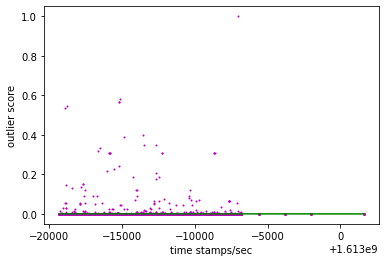

In [46]:
import numpy as np
import matplotlib.pyplot as plt


def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)
 
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 1)
        # predicted response vector
    y_pred = b[0] + b[1]*x
 
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
 
    # putting labels
    plt.ylabel('outlier score')
    plt.xlabel('time stamps/sec')
 
    # function to show plot
    plt.show()
 
def main():
    # observations / data
    x = np.array(df['time'].tolist())
    y = np.array(df['score'].tolist())
    
    # estimating coefficients
    b = estimate_coef(x, y)
    print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(b[0], b[1]))
    # plotting regression line
    plot_regression_line(x, y, b)
 
if __name__ == "__main__":
    main()

Plot of features and outliers as cooler colors to look for trends

In [48]:
#labels = df.columns
#for i in range(len(labels)):
#    for j in range(len(labels)):
#        plt.figure(figsize=(20,20))
#        plt.title('Local Outlier Factor (color)')
#        xi = i
#        yi = j
#        scatter = plt.scatter(df.values[:,xi], df.values[:,yi], c=score, s=2 * (score**2)/max(score)**2, cmap='coolwarm')  
#        plt.colorbar(scatter)
#        plt.xlabel(labels[i])
#        plt.ylabel(labels[j])
#        plt.show()

### The new column 'score' is the range of the response being an outlier. The bigger the number is, the more unusual behavior the machine detects

In [49]:
df['score'] = df['score'].abs()
df['score'].std()
len(df)

44465

In [50]:
detected_responses = df[df['score']>df['score'].std()+df['score'].mean()]
df['score'].std()
df['score'].mean()

0.0003384090134607489

In [51]:
sorted_detection = df.sort_values(by=['score'],ascending=False)
sorted_detection.head()

sourceIP        destIP  numOfRequest          time  acceptanceRate  \
43490  1.721620e+07  2.721118e+10           1.0  1.612993e+09           100.0   
14554  1.721615e+07  8.116922e+09           1.0  1.612985e+09           100.0   
14356  1.721615e+07  8.116922e+09           1.0  1.612985e+09           100.0   
14306  1.721615e+07  8.116922e+09           2.0  1.612985e+09           100.0   
2533   3.116317e+10  1.721614e+07           1.0  1.612981e+09             0.0   

       averageTimeTook     score  
43490             12.0  1.000000  
14554             12.0  0.580792  
14356             13.0  0.568023  
14306             13.0  0.567043  
2533              16.0  0.546329

In [52]:
sorted_detection.to_csv('result.csv')